In [3]:
pip install --user velocyto scprep 

     |████████████████████████████████| 204kB 3.9MB/s eta 0:00:01
     |████████████████████████████████| 51kB 11.7MB/s eta 0:00:01
     |████████████████████████████████| 51kB 17.0MB/s eta 0:00:01
  Stored in directory: /home/dan/.cache/pip/wheels/e0/10/47/5a2aa6a7179b17b50a19cdba1df71798ade77e7d9ce98c5300
  Stored in directory: /home/dan/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Stored in directory: /home/dan/.cache/pip/wheels/6c/fb/3d/5c43eb691bd92a3ddd0ebeb6e7e78ceaf3ae1cb8d54b89a7fb
Successfully built velocyto loompy numpy-groupies
Note: you may need to restart the kernel to use updated packages.


In [1]:
import velocyto
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import loompy
import pandas as pd
import scprep
import matplotlib
import os
import tarfile
import phate

# Running RNA-velocity on the EB dataset

Calculating RNA velocity involves two main steps:
1. Generate loom files with information about spliced and unspliced genes
2. Estimating the rate of transcription for each gene
3. Predicting future cell state given the spliced/unspliced ratio of genes in each cell

We already performed the first step because this takes a long time and a lot of computational resources. If you want to learn how to generate loom files, please consult the RNA velocity tutorials (http://velocyto.org/velocyto.py/tutorial/index.html). The syntax is fairly straightforward.

In this exercise, we will perform steps 2 and 3 to estimate the transcriptional velocity for each cell.

## 1. Downloading and loading the loom files

Running estimating RNA velocity requires a special `VelocytoLoom` object. Here we create this object using the loom file generated from the fastq files.

### Downloading the `loom` files


In [2]:
home = os.path.expanduser('~')
download_path = os.path.join(home, 'scRNAseq', '2017_Krishnaswamy_EB_velocity.tar.gz')

if not os.path.exists(os.path.dirname(download_path)):
    os.makedirs(os.path.dirname(download_path))

# Download the data tarball
if not os.path.exists(download_path):
    scprep.io.download.download_google_drive('1FDDSWtSZcdQUVKpk-mPCZ8Ji1Fx8KSz9',download_path)

# Extract data directory
tf = tarfile.open(download_path)
tf.extractall(os.path.dirname(download_path))

# Format the data paths
data_dir = os.path.join(os.path.dirname(download_path), '2017_Krishnaswamy_EB_velocity')

### Loading the loom files

Designed for large omics datasets, loom files are essentially specially formatted HDF5 tables that store data and metadata in a single container. You can read more about loom files here: http://loompy.org/.

We will load the `loom` files with `velocyto`, the RNA velocity toolkit.

In [3]:
# Load the data
vlm = velocyto.VelocytoLoom(os.path.join(data_dir,'EBT_velocity.loom'))

# Keep only cells that passed QC as determined in Moon et al. (2019)
keep_cells = set(np.load(os.path.join(data_dir,'EBT_filtered_cells.npy')))

data_phate = pd.read_pickle(os.path.join(data_dir,'EBT_phate_coordinates.pkl'))

#### Processing the loom file

Velocyto has a lot of complicated plotting functions that require attributes be stored in specific slots in order to create the plots showcased in the paper. Because of this, the following code block is a little opaque. As a reminder, all of this code was generated following the Velocyto tutorials, and  you should probably follow their tutorials if you want to run RNA velocity on your data.

In [4]:
# Get the list of kept barcodes from saved numpy, then filter vlm object by them
to_keep = np.array([1 if s in keep_cells else 0 for s in vlm.ca['CellID']]).astype(np.bool)
vlm.filter_cells(to_keep)

# Coerce the data into a nice format
data_phate = np.array([data_phate[cid] for cid in vlm.ca['CellID']])

# Storing sample labels in the column attributes 
samples = ['EBT0_1A', 'EBT2_3B', 'EBT4_5C', 'EBT6_7D', 'EBT8_9E']
vlm.ca['Sample'] = np.array([s[:7] for s in vlm.ca['CellID']])
sample_index_map = dict(zip(np.unique(vlm.ca['Sample']), range(5)))
vlm.ca['Sample_idx'] = np.array([sample_index_map[s] for s in vlm.ca['Sample']])

# Adding nicely formatted cluster labels
nice_samples = ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"]
sample_nice_map = dict(zip(samples, nice_samples))
vlm.ca['Sample_nice'] = np.array([sample_nice_map[s] for s in vlm.ca['Sample']])
vlm.cluster_labels = vlm.ca['Sample_nice']

# Adding PHATE coordinates to the `vlm` object
vlm.ts = data_phate
cmap = matplotlib.cm.get_cmap('Spectral')
vlm.colorandum = np.array([dict(zip(samples, cmap(np.linspace(0,1,5))))[s] for s in vlm.ca['Sample']])

#### Plotting PHATE coordinates

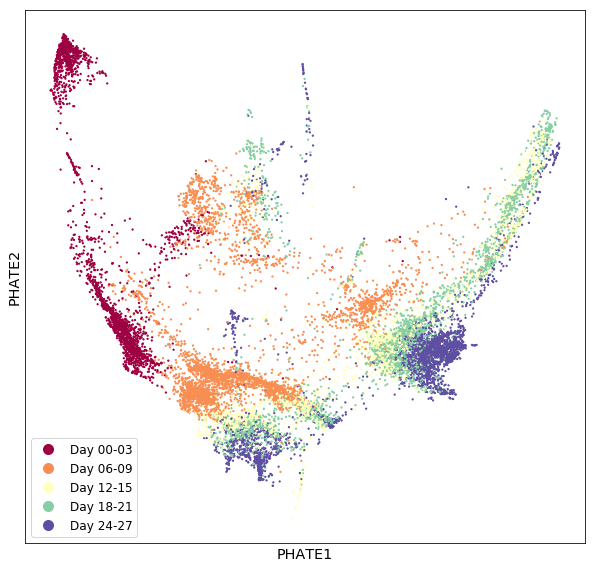

In [5]:
ax = scprep.plot.scatter2d(data_phate, c=vlm.ca['Sample_nice'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")
ax.set_aspect('equal')

#### Plotting the fraction of spliced and unspliced reads in each sample

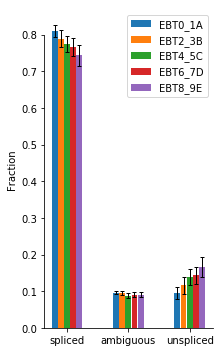

In [6]:
vlm.plot_fractions()

### Discussion

In pairs, discuss the following questions

1. What do you notice about the number ratio of spliced to unspliced genes?
2. What does this imply about the rate of transcription over time?

## 2. Gene Filtering

Just as we filter and preprocess RNA expression data, we need to do some preprocessing of the `VelocytoLoom` file.

### Score detection levels

Here we do a simple filtering based on the minimum number of cells in which a given gene is detected. We then throw away lowly expressed genes.

In [7]:
# Identify genes with adequate baseline expression
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)

# Keep only genes passing detection threshold
vlm.filter_genes(by_detection_levels=True)

### Filter highly variable genes

Here, we only keep genes with a high coefficient of variation with respect to mean expression.

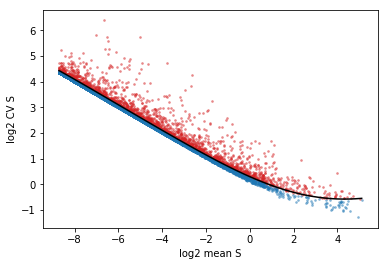

In [8]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

### Filter genes by cluster expression

Here, we keep genes that have adequate spliced and unspliced counts in clusters of the data. The following methods will do the clustering and ensure that we have sufficient spliced and unspliced counts throughout the full dataset.

In [9]:
# Consider number of spliced and unspliced counts globally
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0, 
                           min_expr_counts_U=25, min_cells_express_U=20)

# Consider number of spliced and unspliced counts in clusters
vlm.score_cluster_expression(min_avg_U=0.01, min_avg_S=0.08)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)

### Normalize the spliced and unspliced counts by library size 

In [10]:
# Normalize Spliced and Unspliced gene expression matrices by library size.
vlm._normalize_S(relative_size=vlm.initial_cell_size,
                 target_size=np.mean(vlm.initial_cell_size))
vlm._normalize_U(relative_size=vlm.initial_Ucell_size,
                 target_size=np.mean(vlm.initial_Ucell_size))

### Pick a number of principal components to use for kNN smoothing

Text(0, 0.5, 'Explained Variance')

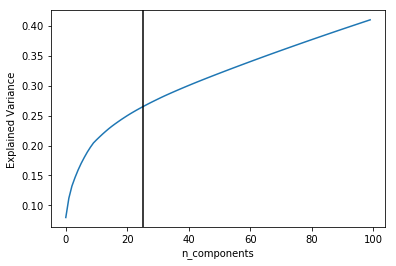

In [11]:
# Pick a number of PCA components
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
#n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
n_comps = 25
plt.axvline(n_comps, c="k")
plt.xlabel('n_components')
plt.ylabel('Explained Variance')

### Gene smoothing

Because not all genes are detected in all cells, the ratio of spliced to unspliced is noisy (just like gene expression, but worse), we want to use local neighborhoods in the data to perform imputation and denoising. This is similar to the MAGIC algorithm discussed earlier, but it doesn't use diffusion. In the MAGIC paper, it was shown that MAGIC performs better than kNN for gene denoising, but this isn't our implementation, so we're not going to worry too much about that.

In [12]:
# Denoise the data using kNN

# Change k here to change how much denoising is performed
k = 5
vlm.knn_imputation(n_pca_dims=n_comps, k=k, 
                   # velocyto uses an algorithm called BalancedKNN
                   # for smoothing. These parameters are go directly
                   # to BalancedKNN
                   balanced=True, b_sight=k*8, b_maxl=k*4, 
                   n_jobs=-1)

### Estimate the rate of transcription

Here, we're going to estimate the rate of transcription for each gene. This involves estimating the steady-state expression for each gene and calculating the rate of transcription as a ratio of the spliced and unspliced molecules in each cell.

In [13]:
# Fit gamma (stable state unspliced to spliced ratio) 
# and calculate gene shift at all cells

# Learn steady-state U/S ratio
vlm.fit_gammas(limit_gamma=False, fit_offset=False)

# Estimate rate of transcription 
vlm.predict_U()

# Calculate individual cell "next state"
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

## Gene Scatterplots

Now that we have estimated the rate of transcription and splicing for each cell, we can inspect how well these curves match the data we're observing. Remember that one assumption of RNA-velocity is that the rate of splicing is constant across all cells in a dataset.

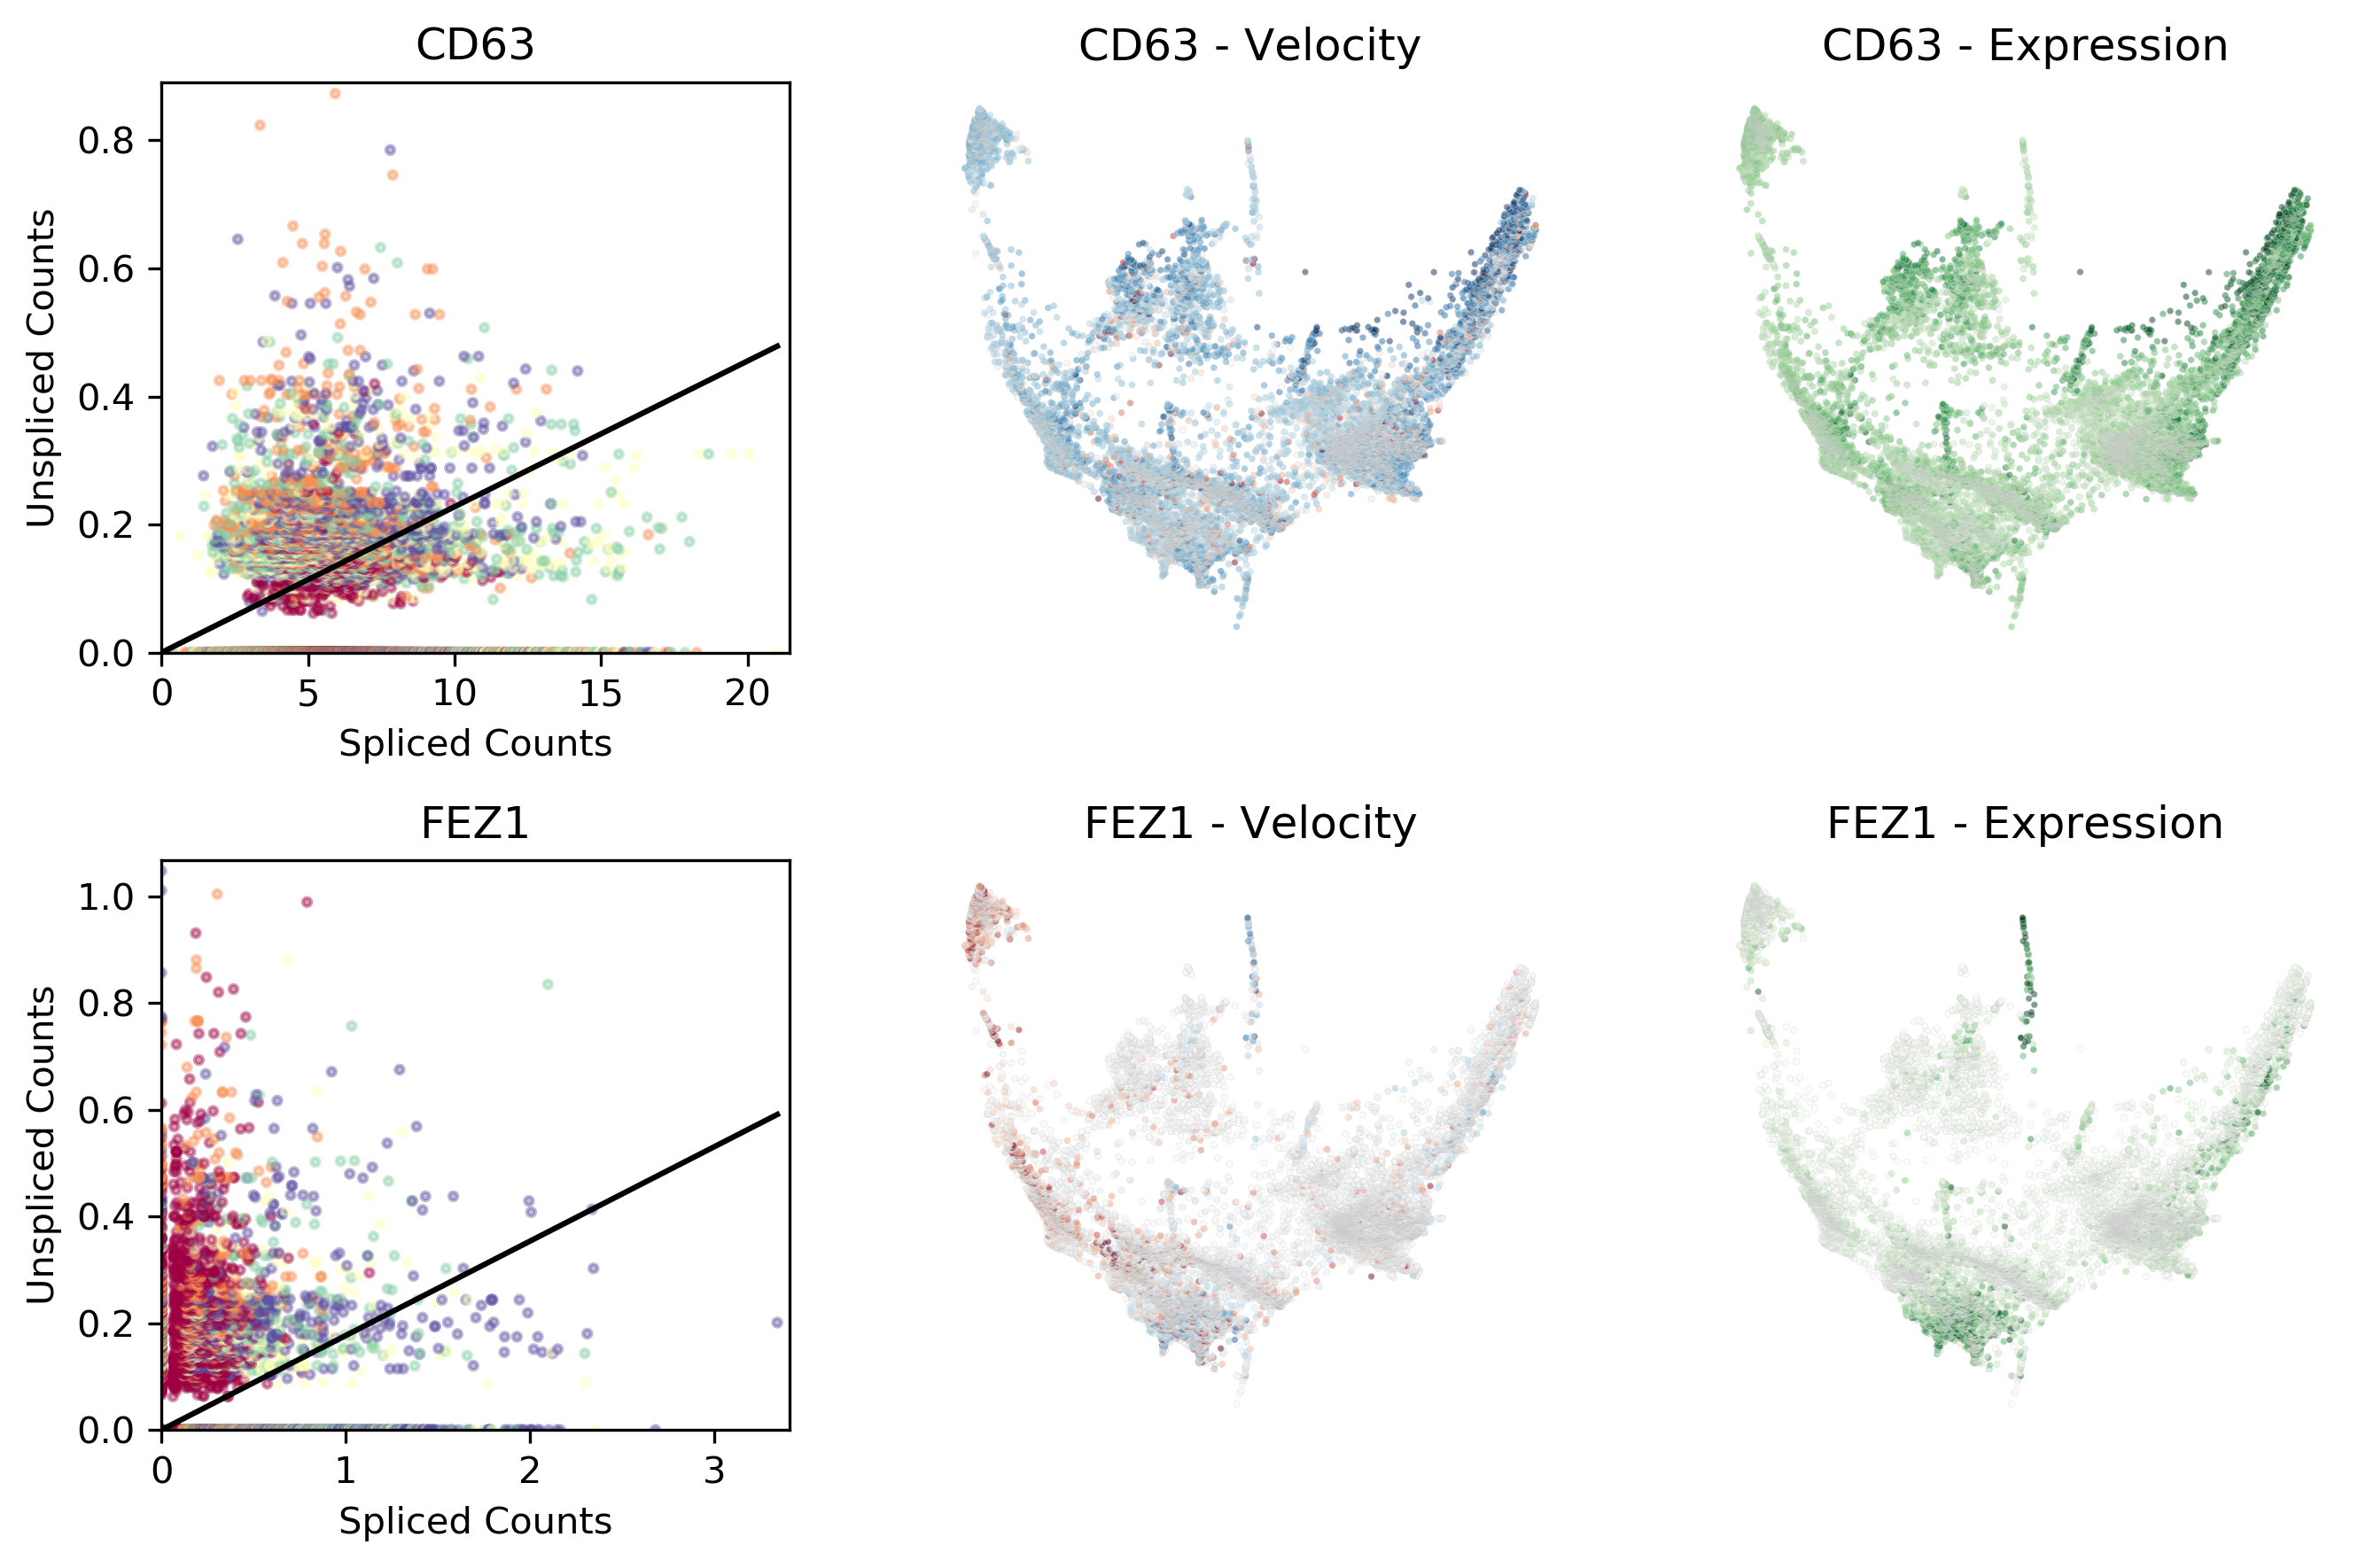

In [14]:
# Plot for a few genes the spliced and unspliced counts, as well as
# The calculated gene velocity, and expression at each cell.
fig = plt.figure(None, (9,6), dpi=300)
gs = plt.GridSpec(2,3)
for i, gn in enumerate(['CD63', 'FEZ1']):
#for i, gn in enumerate(["FOXD3", 'GATA6']):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    except:
        continue
    velocyto.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], s=5, c=vlm.colorandum, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
    plt.ylim(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    plt.xlabel('Spliced Counts')
    plt.ylabel('Unspliced Counts')
    vlm.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)
    plt.title('{} - Velocity'.format(gn))
    vlm.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    plt.title('{} - Expression'.format(gn))

plt.tight_layout()

#### Breakpoint - If you're done, help those around you!

## 3. Estimate transition probabilities

Here we take the set of all predicted "next states" for each cell and estimate a future cell profile. Because each gene estimate is noisy, we take averages of neighbors.

This is the most computationally intensive step of RNA-velocity analysis, so it may take 1-3 minutes to finish.

Also, heads up, you may see several red warnings come up. You can ignore these. They are due to the velocyto implementation and not anything we've done here.

In [15]:
# Estimate the transition direction of each cell in gene space
# This is the most compuationally intensive step.
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=2000, knn_random=True, sampled_fraction=0.5, calculate_randomized=True,
                             n_jobs=-1)

/home/dan/.local/lib/python3.7/site-packages/velocyto/analysis.py:1569: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  p=p) for i in range(neigh_ixs.shape[0])), 0)


#### Calculate the next cell profile in the embedding space

Once we know the expected gene expression profile of each cell, we need to calculate where that cell would appear in the PHATE space to create the velocity plots.

In [16]:
# Calculate from the gene velocity vectors in the embedding space
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)

# Calculate a 50x50 grid of velocities over the embedding space
vlm.calculate_grid_arrows(smooth=0.5, steps=(50, 50), n_neighbors=100)

### Plotting Velocity Vectors

These are the fancy plots highlighted in the RNA velocity paper. Each cell gets an arrow pointing to it's future cell state. You can see the flow of cell states throughout development!

(-116.9431496615558, 119.90876259493223, -94.98529068291008, 130.5978858969067)

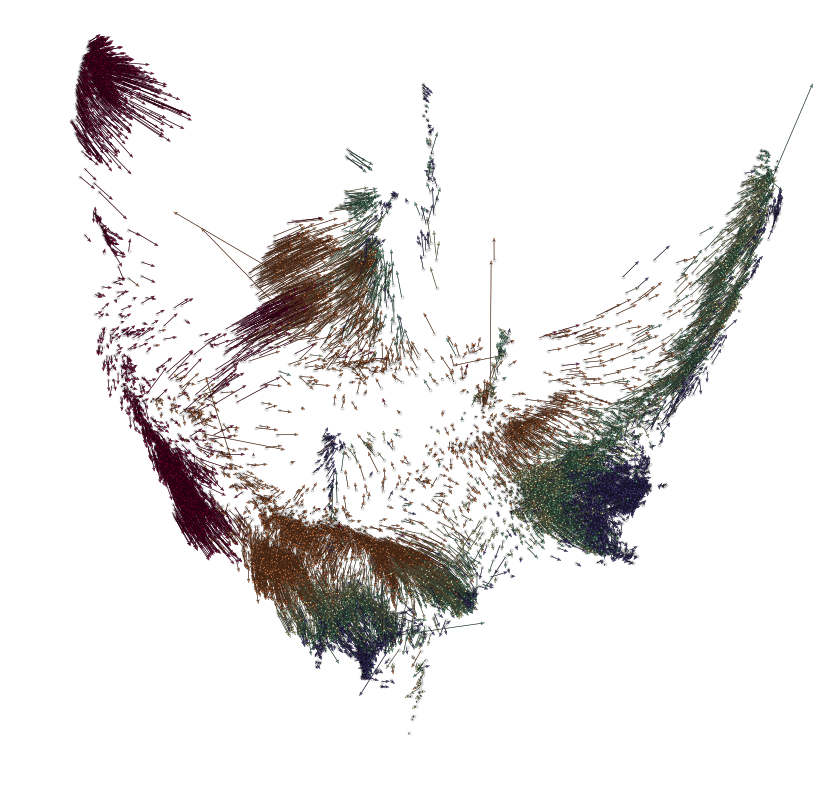

In [17]:
# Plot per cell velocity directions
plt.figure(None,(14,14))
quiver_scale = 10
q_scale=1
ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)

# Plotting each cell using the pyplot scatter function 
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

# Plotting the arrows 
quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color=vlm.colorandum[ix_choice], alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1], 
           q_scale*vlm.delta_embedding[ix_choice, 0], q_scale*vlm.delta_embedding[ix_choice, 1],#units='xy',
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")

In [18]:
# How to get just the arrows
# np.concatenate([vlm.embedding, vlm.delta_embedding], axis=1)
# vlm.velocity is a per cell gene velocity vector

### Plot arrows on a grid

Here we're plotting the average arrow for each section of the grid. This is a much "prettier" plot.

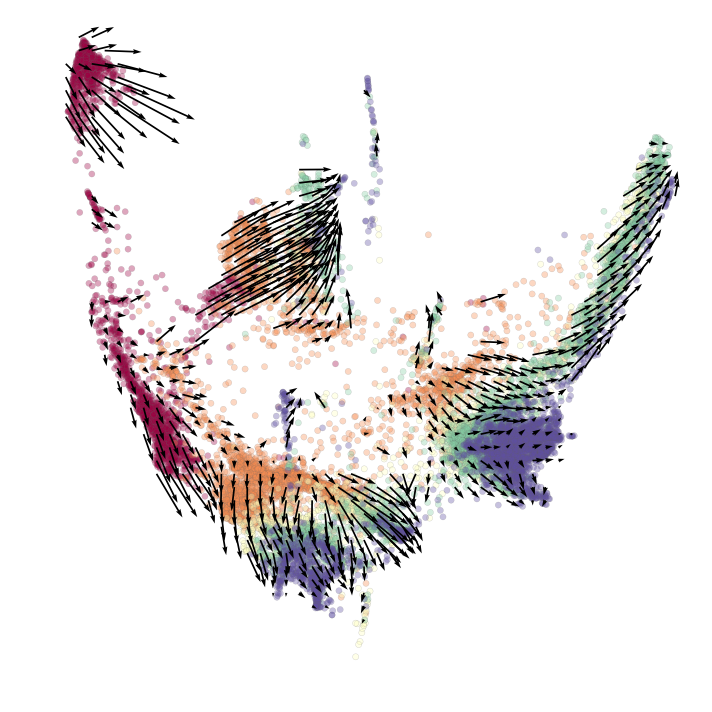

In [19]:
# Plot velocity on grid points smoothing cell velocities.
plt.figure(1,(10,10))

# Plot the arrows
vlm.plot_grid_arrows(quiver_scale=0.5,
     scatter_kwargs_dict={"alpha":0.35, "lw":0.35, 
     "edgecolor":"0.4", "s":38, "rasterized":True},
     plot_random=False)

plt.tight_layout()
#plt.savefig('/home/dan/burkhardt/SingleCellWorkshop/lectures/Trajectory_Inference/img/RNAvelocity.PHATE_grid.png', dpi=300)

### Discussion

1. Looking at this data, how many end points do you think exist in the EB dataset?

## 4. Identify genes with largest changing velocity

In [20]:
data = pd.DataFrame(vlm.U + vlm.S, index=vlm.ra['Gene'], columns=vlm.ca['CellID']).T

In [21]:
data = scprep.normalize.library_size_normalize(data)
data = scprep.transform.sqrt(data)

### Cluster the data

In [47]:
phate_op = phate.PHATE(verbose=False).fit(data)

phate_clusters = phate.cluster.kmeans(phate_op, n_clusters=12)
phate_clusters = scprep.utils.sort_clusters_by_values(phate_clusters, data_phate[:,0])

cm = plt.cm.tab20(np.linspace(0, 1, 20))
cmap = {cl:cm[cl] for cl in np.unique(phate_clusters)}
vlm.colorandum = np.array([cm[cl] for cl in phate_clusters])

#### Plotting clusters

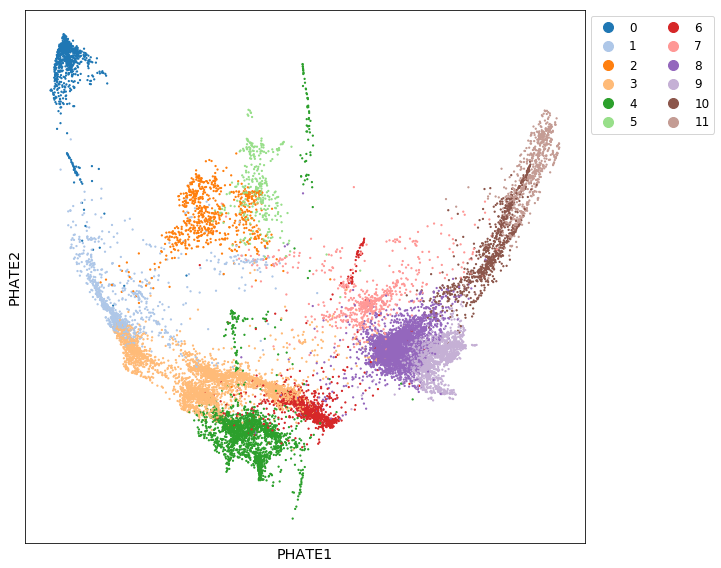

In [48]:
# Plot clusters
ax = scprep.plot.scatter2d(data_phate, c=vlm.colorandum, figsize=(12,8),
                      ticks=False, label_prefix="PHATE")
ax.set_aspect('equal')
scprep.plot.tools.generate_legend(cmap, plt.gca(), bbox_to_anchor=(1,1))

#### Plotting velocity on clusters

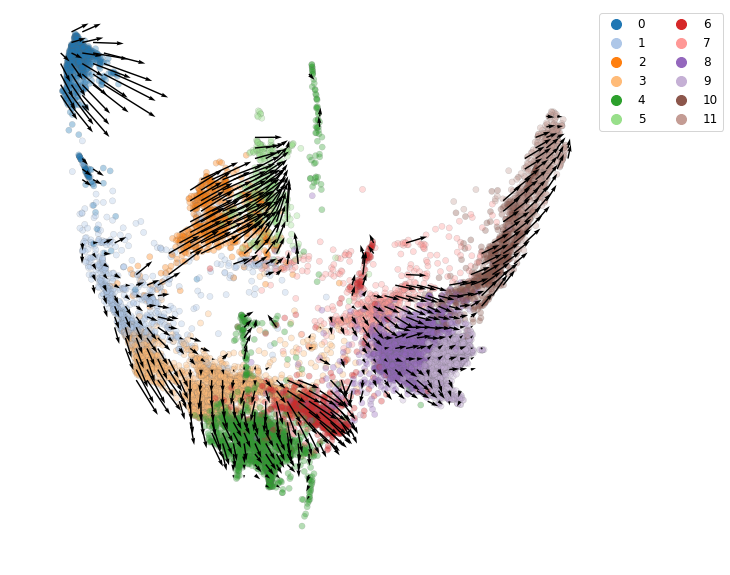

In [49]:
# Plot velocity on grid points smoothing cell velocities.
plt.figure(1,(10,10))

cm = plt.cm.tab20(np.linspace(0, 1, 20))
cmap = {cl:cm[cl] for cl in np.unique(phate_clusters)}
vlm.colorandum = np.array([cm[cl] for cl in phate_clusters])

# Plot the arrows
vlm.plot_grid_arrows(quiver_scale=0.5,
     scatter_kwargs_dict={"alpha":0.35, "lw":0.35, 
     "edgecolor":"0.4", "s":38, "rasterized":True},
     plot_random=False)

scprep.plot.tools.generate_legend(cmap, plt.gca(), bbox_to_anchor=(1,1))

### Running slingshot informed by RNA velocity

Go back and compare these plots to the Slingshot results from the "02_Embryoid_body_trajectory_inference" notebook. Do you think there might be other endpoints in this data?

#### Subsample the data

In [75]:
import magic

In [76]:
np.random.seed(42)
data_magic = magic.MAGIC(t=4).fit_transform(data)
all_subsample = scprep.select.subsample(data_phate,
                                        data_magic,
                                        phate_clusters, 
                                        vlm.colorandum, n=6000)
data_phate_subsample, data_magic_subsample, clusters_subsample, colors_subsample = all_subsample

Calculating MAGIC...
  Running MAGIC on 16819 cells and 1084 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.81 seconds.
    Calculating KNN search...
    Calculated KNN search in 31.97 seconds.
    Calculating affinities...
    Calculated affinities in 31.09 seconds.
  Calculated graph and diffusion operator in 64.64 seconds.
  Calculating imputation...
  Calculated imputation in 2.69 seconds.
Calculated MAGIC in 67.70 seconds.


#### Plot subsampled data

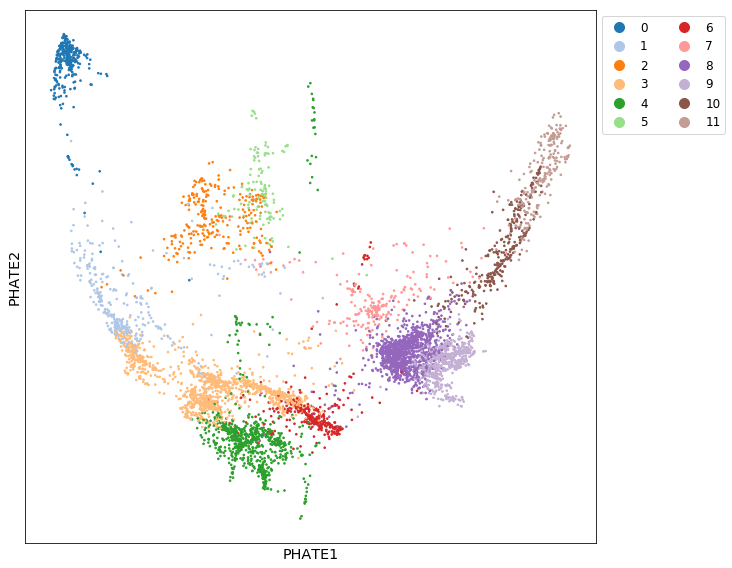

In [77]:
ax = scprep.plot.scatter2d(data_phate_subsample, c=colors_subsample, figsize=(12,8),
                      ticks=False, label_prefix="PHATE")
ax.set_aspect('equal')
scprep.plot.tools.generate_legend(cmap, plt.gca(), bbox_to_anchor=(1,1))

In [78]:
import time
tic = time.time()
results = scprep.run.Slingshot(data_phate_subsample, clusters_subsample, start_cluster=0, end_cluster=[4, 9,11,2] )
print('Ran Slingshot in {:.2f} seconds'.format(time.time() - tic))

Ran Slingshot in 92.27 seconds


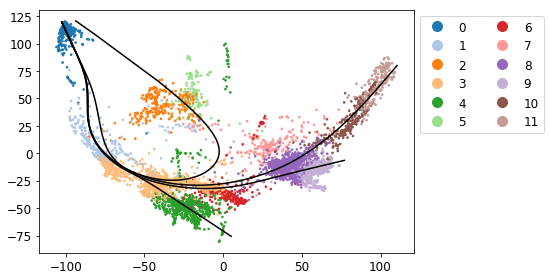

In [79]:
ax = scprep.plot.scatter2d(data_phate_subsample, c=colors_subsample)
for curve in results['curves']:
    ax.plot(curve[:,0], curve[:,1], c='k')
scprep.plot.tools.generate_legend(cmap, plt.gca(), bbox_to_anchor=(1,1))

### Calculate the average slingshot pseudotime per cell

In [80]:
# To calculate the average slingshot pseudotime, we can use np.nanmean
avg_slingshot_pseudotime = np.nanmean(results['pseudotime'], axis=1)

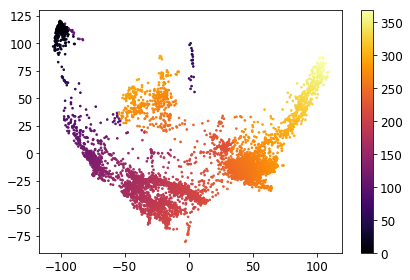

In [81]:
ax = scprep.plot.scatter2d(data_phate_subsample, c=avg_slingshot_pseudotime)

### Calculate average velocity per cluster

Here we calculate the velocity for each gene in each cell, then use `pd.DataFrame.groupby()` to calculate the average velocity in each cluster.

Each row of the resulting dataset corresponds to a cluster and each column is a gene.

In [56]:
velocity = pd.DataFrame(vlm.velocity, index=vlm.ra['Gene'], columns=vlm.ca['CellID']).T

mean_velocity_per_cluster = velocity.groupby(phate_clusters).mean()
mean_velocity_per_cluster.head()

MRPL20     ACOT7      ENO1  CTNNBIP1       SRM      RCC2     LUZP1  \
0 -0.137271 -0.044426 -0.078669 -0.003213 -0.070484 -0.043962 -0.028873   
1 -0.136264 -0.034476 -0.082997 -0.056382 -0.052810 -0.017270 -0.028485   
2 -0.092455 -0.013056 -0.070021 -0.035081 -0.027203 -0.029111 -0.029431   
3 -0.081199 -0.025979 -0.095892 -0.044361 -0.032707 -0.000020 -0.022777   
4 -0.052030 -0.033951 -0.131434 -0.019638 -0.031795  0.004509  0.002532   

     HNRNPR       ID3    SRSF10  ...    MAGED1     KIF4A      PGK1    DIAPH2  \
0 -0.023171 -0.017351 -0.351371  ...  0.121917  0.005544 -0.043551  0.047383   
1 -0.032485 -0.048293 -0.284844  ...  0.071399  0.000540 -0.026759  0.055831   
2 -0.010665 -0.019745 -0.015911  ...  0.069619 -0.001790 -0.026242  0.111677   
3 -0.021467 -0.032328  0.023892  ...  0.076570  0.009665 -0.034449  0.061564   
4 -0.009412 -0.041390  0.295829  ...  0.056703  0.012190 -0.044035  0.038285   

     RPL36A      BEX3     PRPS1      PLS3      DKC1    EIF1AY  
0 -0.136307 -0.203894 -0.029076 -0.055837 -0.057507 -0.072404  
1 -0.145288 -0.182526 -0.021465 -0.016736 -0.056370 -0.071801  
2 -0.130043 -0.151646 -0.016914 -0.011390 -0.037060 -0.047755  
3 -0.141540 -0.125293 -0.027503 -0.023599 -0.053640 -0.039190  
4 -0.088397 -0.084468 -0.022815  0.001253 -0.032665 -0.010447  

[5 rows x 1084 columns]

#### Print the genes with the highest mean velocity

In [73]:
mean_velocity_per_cluster.loc[0].abs().sort_values(ascending=False).head(20)

MALAT1      12.214923
RPS3        11.614136
RPS21        1.699250
RPS25        1.430928
RPL34        1.104442
RPLP2        0.949465
EEF2         0.908683
RPL30        0.741651
ATP5F1B      0.596271
EPCAM        0.592588
SNRPD1       0.539530
FAU          0.536825
PHB          0.510913
PSMB3        0.509908
SYT1         0.471259
SNRPB        0.465490
SERPINH1     0.450996
UBL5         0.403681
SELENOW      0.397039
PTMA         0.389295
Name: 0, dtype: float64

#### Plotting expression ordered by pseudotime

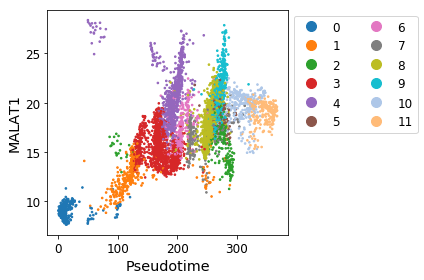

In [83]:
scprep.plot.scatter(avg_slingshot_pseudotime, data_magic_subsample['MALAT1'], 
                    c=clusters_subsample, xlabel='Pseudotime', legend_anchor=(1,1))

### Discussion

In each pair:

1. Pick a cluster that looks like it has high RNA velocity in the above plots
2. Get the top 20 genes with the high average velocity in that cluster
3. Plot the expression of that gene against pseudotime
4. Does pseudotime ordering match the RNA velocity prediction for your cluster?
5. Identify one gene for which pseudotime and RNA velocity agree and one for which they do not